# Do we have a gender bias?

Looking at the data fields one might think of several types of gender-related biases. In the first stage, I listed the possible biases that can be found in the data:
1. Bias in the NPS scoring
2. Bias in attendance  

Then, I went over the list, looking for information in the data to support each of my claims.
But before we do anything, let's take a general look on the data.

In [23]:
def get_date_fields(date):
	day = int(date.split("-")[0])
	month = int(date.split("-")[1])
	year = int(date.split("-")[2])
	return day, month, year

datasetFile = 'joontalks_1487232405444.csv'
# Load the dataset
print "-I- Loading the dataset...."
import csv
from datetime import date
fh = open(datasetFile)
datasetReader = csv.DictReader(fh)
datasetDict = []
for row in datasetReader:
		if ( row['Number of Attendees'] == '' ):
			row['Number of Attendees'] = 1
        
		# Add speaker seniority field
		day, month, year = get_date_fields(row['Speaker\'s Joining Date'])
		join_date = date(year, month, day)
		day, month, year = get_date_fields(row['Session Date'])
		session_date = date(year, month, day)
		speaker_seniority = (session_date - join_date).days / 352
		
		row['Speaker Seniority'] = speaker_seniority

		# Add client seniority field
		day, month, year = get_date_fields(row['Client\'s Joining Date'])
		join_date = date(year, month, day)
		client_seniority = (session_date - join_date).days  / 352

		row['Client Seniority'] = client_seniority
        
		datasetDict.append(row)
        
print "-I- Found",len(datasetDict),"samples in the dataset"
print "-I- Found the following features:",datasetReader.fieldnames
# Gender distribution between the speakers
female_rows = [row for row in datasetDict if (row['Speaker Gender'] == 'female')]
male_rows = [row for row in datasetDict if row['Speaker Gender'] == 'male']
print "-I- Found",len(female_rows),"Female Speakers"
print "-I- Found",len(male_rows),"Male Speakers"

-I- Loading the dataset....
-I- Found 107244 samples in the dataset
-I- Found the following features: ['Session Date', 'Subject', 'Field', 'Session Length (Min)', 'Number of Attendees', 'NPS Score', 'Speaker', 'Speaker Gender', "Speaker's Joining Date", 'Client Company', 'Client Department', "Client's Joining Date", 'Number of Exchanged Emails Between Client And Speaker', 'Profile Image']
-I- Found 28421 Female Speakers
-I- Found 72353 Male Speakers


One important thing we should note here is that our data is very unblanaced in terms of gender distribution. We have nearly 2.5 times more male speakers.

Now, let us look for evidence for the first bias: bias in NPS scoring.

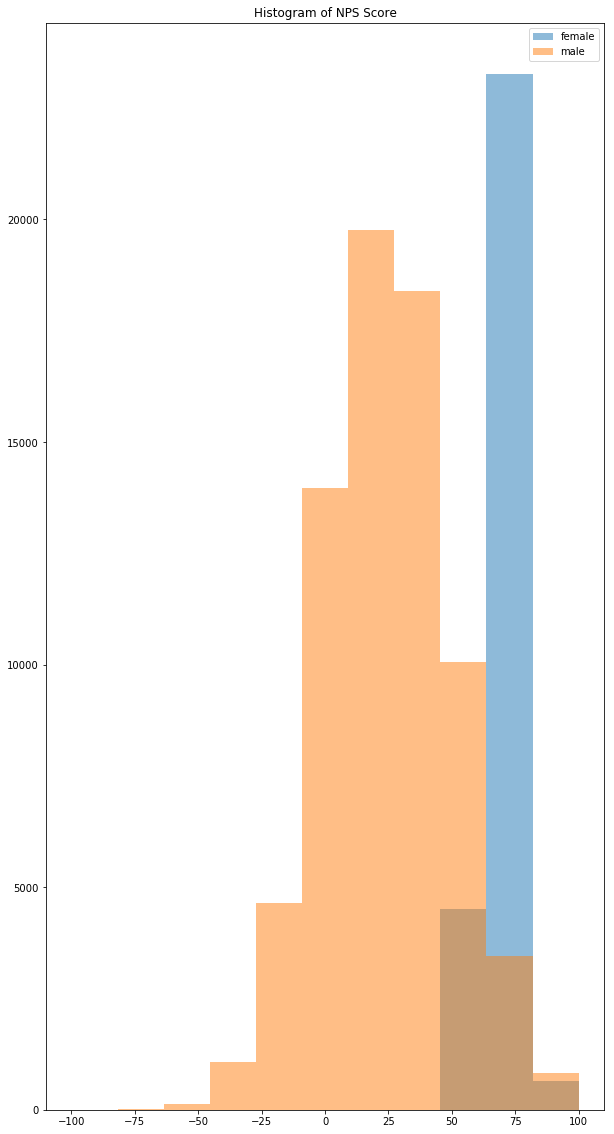

-I- Female Average NPS 69.4810879187
-I- Male Average NPS 24.5401875708


In [24]:
# Gender bias in NPS score (Average)
female_nps_rows = [float(row['NPS Score']) for row in datasetDict if (row['Speaker Gender'] == 'female')]
male_nps_rows = [float(row['NPS Score']) for row in datasetDict if row['Speaker Gender'] == 'male']
import matplotlib.pyplot as plt
plt.figure(figsize=(10,20))
plt.hist(female_nps_rows, range = (-100,100), bins = 11, label = 'female', alpha = 0.5)
plt.title("Histogram of NPS Score")
plt.hist(male_nps_rows, range = (-100,100), bins = 11, label = 'male', alpha = 0.5)
plt.legend()
plt.show()

female_nps_avg = sum([float(row['NPS Score']) * int(row['Number of Attendees']) for row in datasetDict if (row['Speaker Gender'] == 'female')]) / sum([int(row['Number of Attendees']) for row in datasetDict if (row['Speaker Gender'] == 'female')])
male_nps_avg = sum([float(row['NPS Score']) * int(row['Number of Attendees']) for row in datasetDict if (row['Speaker Gender'] == 'male')]) / sum([int(row['Number of Attendees']) for row in datasetDict if (row['Speaker Gender'] == 'male')])
print "-I- Female Average NPS",female_nps_avg
print "-I- Male Average NPS",male_nps_avg

We can clearly see that the NPS score histogram of the males is centered around a value which is much smaller than that of females. 

Question: Do people tend to give better scores to female speakers?
Answer: Maybe. However, another possible explanation is that this is more related to the field of the talk of female speakers, fields that attract higher scores: gender --> field --> score, or possibly related to how senior is the speaker on JoonTalks gender --> seniority --> score

We will now examine the following relationships:
1. The relationship between the field of the talk and NPS scores
2. The relationship between the seniority of the speaker and NPS scores

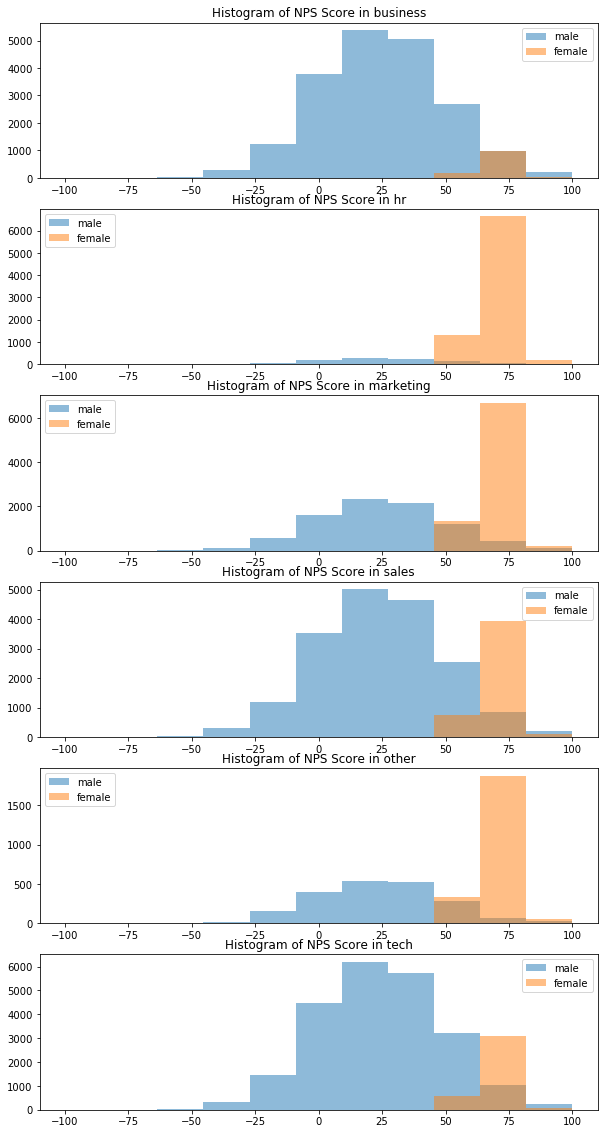

In [34]:
# NPS histogram vs. field vs. gender
speaker_fields = list(set([row['Field'] for row in datasetDict]))
genders = list(set([row['Speaker Gender'] for row in datasetDict if row['Speaker Gender'] != '']))
plt.figure(figsize=(10,20))
cnt = 1
for field in speaker_fields:
    plt.subplot(len(speaker_fields),1,cnt)
    for gender in genders:        
        nps_rows = [float(row['NPS Score']) for row in datasetDict if row['Field'] == field and row['Speaker Gender'] == gender]
        plt.hist(nps_rows, range = (-100,100), bins = 11, label = gender, alpha = 0.5)
        plt.title("Histogram of NPS Score in %s"%(field))       
    plt.legend()
    cnt = cnt + 1

plt.show()

1. The relationship between the field of the talk and NPS scores  
We can see that the gap of NPS score between the genders is consistent across fields. This means that our suggested explanation of gender --> field --> score is invalid.

In [26]:
# NPS vs seniority vs gender
from scipy.stats import linregress
#plt.figure(figsize=(10,20))
cnt = 1
for field in speaker_fields:
    #plt.subplot(len(speaker_fields),1,cnt)
    for gender in genders:
        seniority_rows = [float(row['Speaker Seniority']) for row in datasetDict if row['Field'] == field and row['Speaker Gender'] == gender]
        nps_rows = [float(row['NPS Score']) for row in datasetDict if row['Field'] == field and row['Speaker Gender'] == gender]
        regression = linregress(seniority_rows, nps_rows)
        slope = regression[0]
        pvalue = regression[3]
        print "For",gender,"in the field of",field,"the p-value is",pvalue,"and the slope is",slope
    cnt = cnt + 1
    
#plt.show()

For male in the field of business the p-value is 0.562750562782 and the slope is 0.143172012138
For female in the field of business the p-value is 0.537665604057 and the slope is 0.182234354958
For male in the field of hr the p-value is 0.326389682861 and the slope is 1.28019201906
For female in the field of hr the p-value is 0.800661981045 and the slope is -0.025511841563
For male in the field of marketing the p-value is 0.664362883905 and the slope is 0.165151352186
For female in the field of marketing the p-value is 0.435047927304 and the slope is -0.0775555597034
For male in the field of sales the p-value is 0.802069835018 and the slope is -0.0616027658923
For female in the field of sales the p-value is 0.267829415985 and the slope is 0.128361838857
For male in the field of other the p-value is 0.51895534129 and the slope is 0.51121155721
For female in the field of other the p-value is 0.627800755128 and the slope is 0.0975153888223
For male in the field of tech the p-value is 0.34

2. The relationship between the seniority of the speaker and NPS scores
Looking at the above numbers, and recalling that a smaller p-value is "better", one can see that there is no clear linear relation between the seniority of the speaker and its nps score in nearly all fields across genders. However, in the case of females in the tech field the p-value is noticably smaller than the rest, suggesting that females are less appreciated in the tech field unless they're senior. 
This result weeken our hypothesis that it is the seniority that is responsible for the gap rather than the gender itself.

Now, what about bias in the number of attendees?

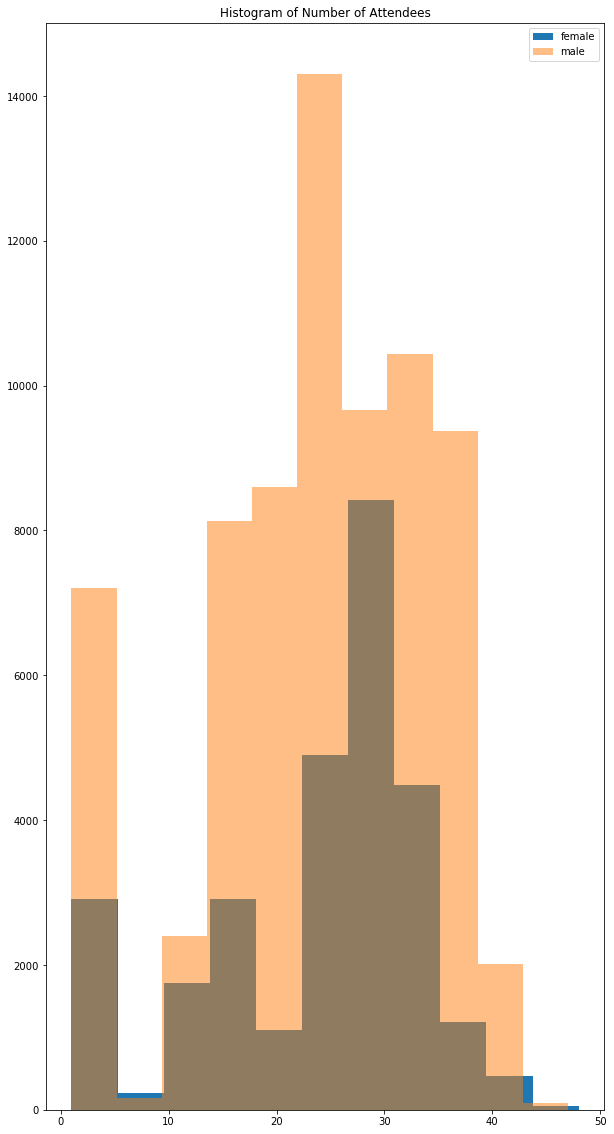

-I- Female Average Attendees 26
-I- Male Average Attendees 26


In [18]:
# Gender bias in attendees
female_att_rows = [int(row['Number of Attendees']) for row in datasetDict if (row['Speaker Gender'] == 'female')]
male_att_rows = [int(row['Number of Attendees']) for row in datasetDict if row['Speaker Gender'] == 'male']
plt.figure(figsize=(10,20))
plt.hist(female_att_rows, bins = 11, label='female')
plt.title("Histogram of Number of Attendees")
plt.hist(male_att_rows, bins = 11, label='male', alpha = 0.5)
plt.legend()
plt.show()

female_att_avg = sum([att for att in female_att_rows if ( att > 1 )])/len([att for att in female_att_rows if ( att > 1 )])
male_att_avg = sum([att for att in male_att_rows if ( att > 1 )])/len([att for att in male_att_rows if ( att > 1 )])
print "-I- Female Average Attendees",female_att_avg
print "-I- Male Average Attendees",male_att_avg

The width of the two distributions and their average are the same, indicating that both genders are attended equally. But what if we inspected each field separately?

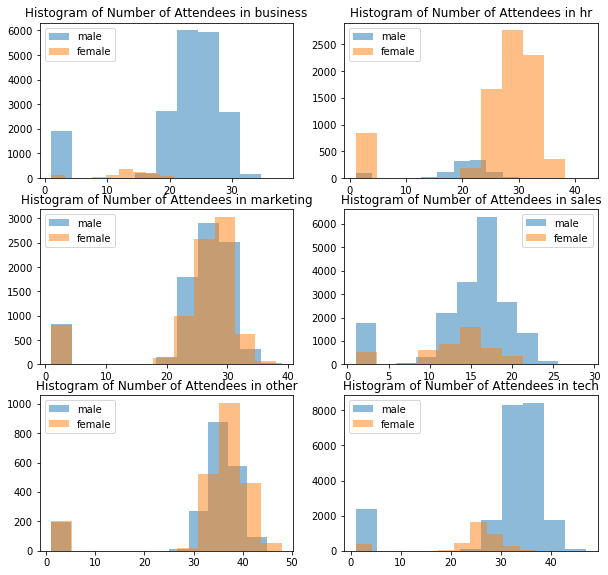

In [33]:
# Gender bias in attendees
plt.figure(figsize=(10,20))
cnt = 1
for field in speaker_fields:    
    for gender in genders:
        att_rows = [int(row['Number of Attendees']) for row in datasetDict if (row['Speaker Gender'] == gender and row['Field'] == field)]
        plt.subplot(len(speaker_fields),2,cnt)
        plt.hist(att_rows, bins = 11, label=gender, alpha = 0.5)
        plt.title("Histogram of Number of Attendees in %s"%(field))
    cnt = cnt + 1
    plt.legend()
plt.show()

Now one can clearly see a pattern in some fields where one gender is being more attended than the other. Indicating a possible gender bias.

# Can we predict gender bias related to attendance?

I choose to work on the second bias: in some fields (like tech, and sales) more people will attend a talk for a speaker with a gender that conforms with the "strong" gender in the field (for example, in the tech field talks by males have higher attendance)  

Now, my goal is to build a classifier that given a talk can predict wether or not there is a gender bias affecting the number of attendees. Since we don't have a "bias exists" or "bias does not exists" labels, we have to think of an alternative way to make the prediction.

Gender bias in this case means that if we trained two models:  
1. Predicts the number of attendees to a talk given all the information BUT the gender of the speaker
2. Predicts the number of attendees to a talk given all the information
If bias exists, the two predictions should be very (what does "very" mean?) different.

What model to use? For simplicity, and for the strength of the model, I will choose a random forest regressor.
To train the regressor, we will have to first define the features. In my case I chose to use the following: talk field, speaker's seniority [years], client seniority [years], client department, did they exchange emails?, does the speaker have profile picture?  

We can notice that some of our features are continous, and some are categorical. To be able to train the model, we will have to do some pre processing to our data. One method is to convert each categorical feature with a set of features representing a one-hot vector encoding.

In [170]:
def addFeaturesToRow(row, client_departments, speaker_fields):
    # Speaker's Gender
    gender = row['Speaker Gender']
    if ( gender == 'female' ):
        row['Speaker Female'] = 1
    elif ( gender == 'male' ):
        row['Speaker Female'] = 0
    else:
        row['Speaker Female'] = -1
    # Speaker's Field
    field = row['Field']
    idx = speaker_fields.index(field)
    row['Field 1Hot'] = [0] * len(speaker_fields)
    row['Field 1Hot'][idx] = 1
    # Client Department
    department = row['Client Department']
    idx = client_departments.index(department)
    row['Client Department 1Hot'] = [0] * len(client_departments)
    row['Client Department 1Hot'][idx] = 1
    # Number of Exchanged Emails Between Client And Speaker
    if ( row['Number of Exchanged Emails Between Client And Speaker'] == ''):        
        row['emailsExchanged'] = 0
    else:
        row['emailsExchanged'] = 1
    # Profile Image
    if ( row['Profile Image'] == ''):
        row['profileImage'] = 0
    else:
        row['profileImage'] = 1
    
    return row

def row2XY(row, features, num_features, value_field):
    x = np.ndarray((1, num_features))
    fcount = 0
    for feature in features:
        if ( isinstance(row[feature], types.ListType) ):
            for f in row[feature]:
                x[0, fcount] = int(f)
                fcount = fcount + 1
        else:
            x[0, fcount] = int(row[feature])
            fcount = fcount + 1
    y = float(row[value_field])
    return x, y

# Preparing the data
import types
import numpy as np

client_departments = list(set([row['Client Department'] for row in datasetDict]))
speaker_fields = list(set([row['Field'] for row in datasetDict]))
speaker_genders = list(set([row['Speaker Gender'] for row in datasetDict]))

for i in range(len(datasetDict)):
    row = datasetDict[i]
    datasetDict[i] = addFeaturesToRow(row, client_departments, speaker_fields)

# Convert the data to a matrix with relevant features
features = ['Speaker Female', 'Field 1Hot', 'Client Department 1Hot', \
            'Speaker Seniority', 'Client Seniority', 'emailsExchanged', 'profileImage']
num_features = 5 + len (speaker_fields) + len(client_departments)

value_field = 'Number of Attendees'
data = np.ndarray((len(datasetDict), num_features + 1 ))
for i in range(len(datasetDict)):
    data[i, :num_features], data[i, -1] = row2XY(datasetDict[i], features, num_features, value_field)


In [171]:
from random import shuffle
female_data = data[data[:, 0] == 1, :]
male_data = data[data[:, 0] == 0, :]
shuffle(male_data)

sampleSize = 60000
femaleSize = len(female_data)
maleSize = sampleSize - femaleSize

sample = np.ndarray((sampleSize, num_features + 1 ))
sample[:femaleSize,:] = female_data
sample[femaleSize:sampleSize,:] = male_data[:maleSize]
shuffle(sample)

valSize = int(0.2 * sampleSize)
trainSize = sampleSize - valSize
trainX = sample[:trainSize,:num_features]
trainY = sample[:trainSize,-1]
valX = sample[trainSize:sampleSize,:num_features]
valY = sample[trainSize:sampleSize,-1]

In [174]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(1, min_samples_split = 100)
rfr.fit(trainX, trainY)

predicted_valY = rfr.predict(valX)
mse = sum((predicted_valY - valY) ** 2)/len(valY)
print "-I- MSE on the validation set is",mse

-I- MSE on the validation set is 68.5119663836


Now, let us try our method on a few examples and look at the results.

In [199]:
def biasStrength(rfr, x, y):    
    predy = rfr.predict(x)
    if ( x[0,0] == 0 ):
        x[0,0] = 1
    else:
        x[0,0] = 0
    predy_oposite_gender = rfr.predict(x)
    print "Prediction:",predy
    print "Opposit gender prediction:",predy_oposite_gender
    err = (predy_oposite_gender - predy) ** 2
    div = err/mse * 100 - 1
    return div[0]

for i in [0, 1927, 8237, 20000]:
    row = datasetDict[i]
    print row,"\n"
    x, y = row2XY(row, features, num_features, value_field)
    div = biasStrength(rfr, x, y)
    print div,"%\n"

{'profileImage': 0, "Speaker's Joining Date": '27-10-2014', "Client's Joining Date": '17-10-2014', 'Speaker Female': 1, 'Client Seniority': 1, 'Speaker': 'Lois Rice', 'Session Date': '01-01-2016', 'Profile Image': '', 'Client Department': 'Business Development', 'emailsExchanged': 0, 'Session Length (Min)': '45', 'Client Department 1Hot': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], 'Speaker Gender': 'female', 'Number of Exchanged Emails Between Client And Speaker': '', 'Field': 'marketing', 'NPS Score': '68.0', 'Field 1Hot': [0, 0, 1, 0, 0, 0], 'Client Company': 'Ferry, Kozey and Boehm', 'Female': 1, 'Subject': 'Personal Branding: How to build your badass brand', 'Number of Attendees': '33', 'Speaker Seniority': 1, 'Speaker Gender 1Hot': [0, 0, 1]} 

Prediction: [ 23.86253935]
Opposit gender prediction: [ 21.85925926]
4.85756230842 %

{'profileImage': 0, "Speaker's Joining Date": '28-12-2014', "Client's Joining Date": '02-02-2014', 'Speaker Female': 1, 'Client Seniority': 2, 'Speaker': 'M

[[ 0.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.
   0.  1.  2.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  1.  2.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  2.  1.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
   0.  0.  1.  1.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.
   0.  2.  2.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.
   0.  1.  2.  0.]
 [ 0.  0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   1.  1.  1.  0.]]
